In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 100
import torch
import zuko
import numpy as np
from chainconsumer import ChainConsumer
from tqdm import tqdm
import corner
mpl.rcParams["figure.dpi"] = 150

from bayesian_gradabm.autoregressive_model import run_autoregressive_model, fit_autoregressive_model_pyro
from bayesian_gradabm.conditioner_encoders import RNN
from bayesian_gradabm.plotting import plot_flow_posterior

#torch.autograd.set_detect_anomaly(True)

In [3]:
# Parameters
n_timesteps = 50
true_parameters = torch.tensor([0.5])
sigma_noise = 0.5
encoding_size = 16
device = "cpu"

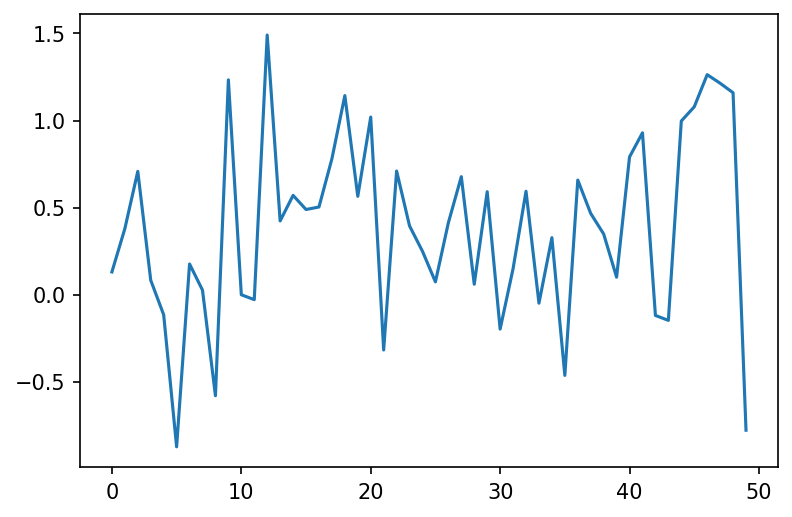

In [4]:
# Observed data
x_obs = run_autoregressive_model(true_parameters.reshape(1,1,-1), n_timesteps=n_timesteps, sigma_noise=sigma_noise)
plt.plot(x_obs.flatten().numpy())


In [5]:
# RNN to encode conditioning data
conditioner_rnn = RNN(input_size=1, hidden_size=64, num_layers=8, output_size=encoding_size, n_timesteps=n_timesteps)

In [6]:
# Define flow
flow = zuko.flows.MAF(len(true_parameters), encoding_size, transforms=8, hidden_features=[64])
flow = flow.to(device)

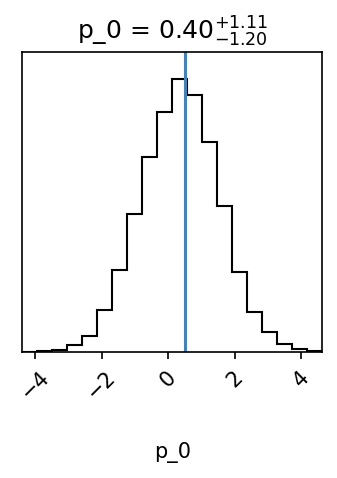

In [7]:
# plot initial posterior for observation
plot_flow_posterior(flow, conditioner_rnn(x_obs[0]), true_parameters)

In [8]:
def clip_samples(samples):
    samples_phi1 = torch.clip(samples[:,:,0].flatten(), -1.0, 1.0)
    #samples_phi2 = torch.clip(samples[:,:,-1].flatten(), min=None, max=torch.min(1-samples_phi1, 1 + samples_phi1))
    #samples = torch.vstack((samples_phi1, samples_phi2)).transpose(0,1)
    samples = samples_phi1.reshape((1, samples.shape[0], samples.shape[1]))
    return samples


In [9]:
def get_forecast_score(flow, x_cond, n_samples=5):
    x_enc = conditioner_rnn(x_cond)
    samples = flow(x_enc).rsample((n_samples,))
    samples = clip_samples(samples)
    samples = samples.reshape(x_cond.shape[0], n_samples, -1)
    xs = run_autoregressive_model(samples, n_timesteps=n_timesteps, sigma_noise=sigma_noise)
    x_cond_m = x_cond.unsqueeze(0).transpose(1,0)
    sqdiff = (x_cond_m - xs)**2
    sum_sqdiff = torch.sum(sqdiff)
    loss = sum_sqdiff / (x_cond.shape[0] * x_cond.shape[1] * n_samples)   #loss_fn(x_cond_m, xs) / n_samples
    return loss

In [10]:
def sample_prior(shape):
    phi_1_prior = torch.distributions.Uniform(-1.0 * torch.ones(shape), torch.ones(shape))
    phi_1 = phi_1_prior.sample()
    #phi_2_prior = torch.distributions.Uniform(-1.0 * torch.ones(shape), torch.min(1-phi_1, 1+phi_1))
    #phi_2 = phi_2_prior.sample()
    #phi = torch.hstack((phi_1, phi_2))
    phi = phi_1
    return phi

In [11]:
# Train model

parameters_to_optimize = list(flow.parameters()) + list(conditioner_rnn.parameters())
print(sum(p.numel() for p in parameters_to_optimize if p.requires_grad))
optimizer = torch.optim.Adam(parameters_to_optimize, lr=1e-4)

n_batches = 1000
n_samples_per_batch = 50
n_samples_per_x_cond = 50

best_loss = np.inf
loss_hist = []
loss_hist_train = []

for it in tqdm(range(n_batches)):
    optimizer.zero_grad()
    # Simulating an AR(1) model
    params = sample_prior((n_samples_per_batch,1,)).reshape((1, n_samples_per_batch, -1))
    x_cond = run_autoregressive_model(parameters=params, n_timesteps=n_timesteps, sigma_noise=sigma_noise)[:,0,...]
    loss = get_forecast_score(flow=flow, x_cond=x_cond, n_samples=n_samples_per_x_cond)
    if torch.isnan(loss):
        break
    loss.backward()
    loss_hist_train.append(loss.item())
    optimizer.step()
    with torch.no_grad():
        params = sample_prior((n_samples_per_batch,1,)).reshape((1, n_samples_per_batch, -1))
        #params = clip_samples(params).reshape(n_samples_per_batch, 1, -1)
        x_cond = run_autoregressive_model(parameters=params, n_timesteps=n_timesteps, sigma_noise=sigma_noise)[:,0,...]
        val_loss = get_forecast_score(flow=flow, x_cond=x_cond, n_samples=n_samples_per_x_cond)
        loss_hist.append(val_loss.item())
        if val_loss.item() < best_loss:
            torch.save(flow.state_dict(), "./best_model.pth")
            best_loss = val_loss.item()
            #print("best validation loss", best_loss)

73824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.61it/s]


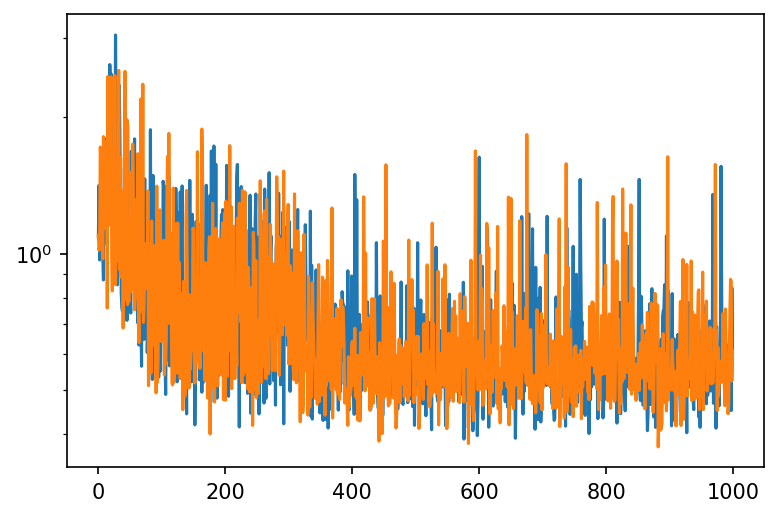

In [12]:
f, ax = plt.subplots()
ax.semilogy(loss_hist_train)
ax.semilogy(loss_hist)

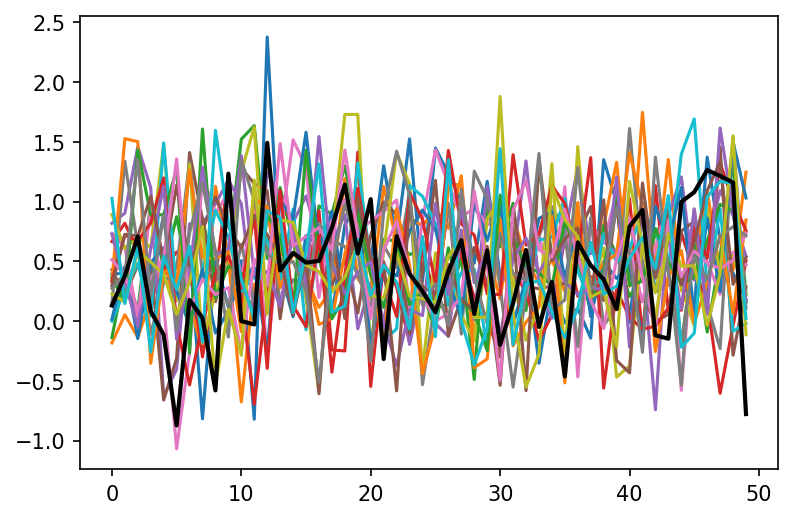

In [13]:
# Plot prediction
N = 20
samples = flow(conditioner_rnn(x_obs[0])).sample((N,))
samples = clip_samples(samples)
xs = run_autoregressive_model(samples, n_timesteps=n_timesteps, sigma_noise=sigma_noise).cpu().numpy()
for i in range(N):
    plt.plot(xs[0,i,:,0])
plt.plot(x_obs[0,0,:,0], color = "black", linewidth=2)

(-2.0, 2.0)

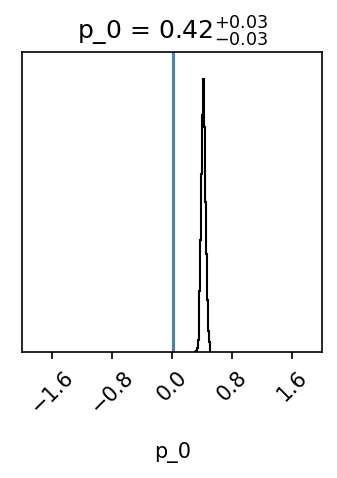

In [14]:
test_theta = sample_prior((1,))
test_x = run_autoregressive_model(test_theta.reshape(1,1,-1), n_timesteps=n_timesteps, sigma_noise=sigma_noise)
flow.load_state_dict(torch.load("./best_model.pth"))
plot_flow_posterior(flow, conditioner_rnn(test_x[0]), test_theta)
plt.xlim(-2,2)

# Comparison with Pyro

In [19]:
mcmc = fit_autoregressive_model_pyro(x_obs, sigma_noise, num_samples=10000, warmup_steps=10000, n_parameters=1)

Sample: 100%|████████████████████████████████████| 20000/20000 [00:19, 1025.82it/s, step size=1.01e+00, acc. prob=0.913]                                                                                                                                                                                                      


In [20]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
phi_1[0,0]      0.39      0.07      0.39      0.27      0.51       nan      1.00

Number of divergences: 0


/Users/arnull/code/pyro/pyro/infer/mcmc/util.py:498: UserWarning: Traceback (most recent call last):
  File "/Users/arnull/code/pyro/pyro/infer/mcmc/util.py", line 496, in wrapped
    val = fn(sample, *args, **kwargs)
  File "/Users/arnull/code/pyro/pyro/ops/stats.py", line 189, in effective_sample_size
    gamma_k_c = autocovariance(input, dim=0)  # N x C x sample_shape
  File "/Users/arnull/code/pyro/pyro/ops/stats.py", line 137, in autocovariance
    return autocorrelation(input, dim) * input.var(dim, unbiased=False, keepdim=True)
  File "/Users/arnull/code/pyro/pyro/ops/stats.py", line 97, in autocorrelation
    raise NotImplementedError(
NotImplementedError: For CPU tensor, this method is only supported with MKL installed.

  warnings.warn(tb.format_exc())


In [21]:
flow_samples = flow(conditioner_rnn(x_obs[0])).sample((10000,))
#flow_samples = clip_samples(flow_samples)

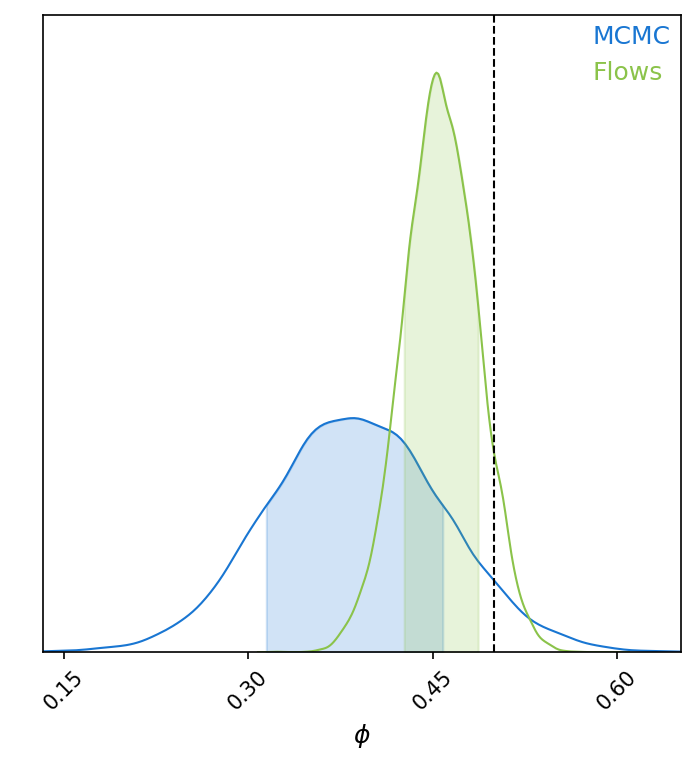

In [22]:
c = ChainConsumer()
c.add_chain(mcmc.get_samples()["phi_1"].numpy(), parameters = ["$\phi$"], name = "MCMC")
c.add_chain(flow_samples.flatten().numpy(), parameters = ["$\phi$"], name="Flows")
c.plotter.plot(truth=true_parameters.numpy(), figsize="column");

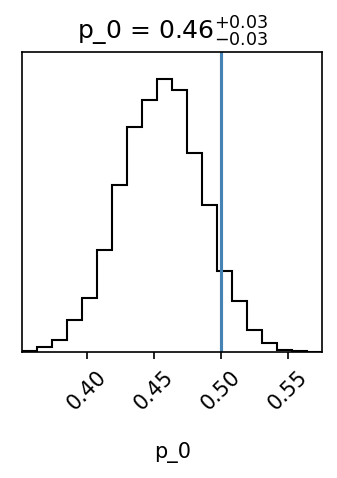

In [18]:
plot_flow_posterior(flow, conditioner_rnn(x_obs[0]), true_parameters)